In [7]:
from classes import *
from utils import *

from typing import List, Set, Tuple, Any, Dict, DefaultDict, Optional
from collections import defaultdict
import linearize_io_helper as io_helper

%load_ext nb_black
%load_ext autoreload
%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [111]:
def linearize_io(spec: List[Call]):
    sort_by_var: DefaultDict[int, List[Call]] = defaultdict(list)
    false_cases: List[CallCAS] = []
    true_cases: List[CallCAS] = []
    
    io_helper.populate_call_bins(spec, sort_by_var, true_cases, false_cases)
    
    writes = io_helper.basic_io_checks(sort_by_var)
    if writes is None:
        return 
    
    if not io_helper.basic_true_cas_checks(true_cases):
        return
    
    io_helper.topological_true_cas_sort(true_cases)

    true_cas_var_groups: List[List[int]] = []
    for true_cas in true_cases:
        for group in true_cas_var_groups:
            if true_cas.compare == group[-1]:
                group.append(true_cas.swap)
                break
        else:
            true_cas_var_groups.append([true_cas.compare, true_cas.swap])


    true_cas_call_groups: List[List[Call]] = []
    for group in true_cas_var_groups:
        all_group_ops: List[Call] = []
        for var in group:
            all_group_ops.extend(sort_by_var[var])
        all_group_ops = list(dict.fromkeys(all_group_ops))
        true_cas_call_groups.append(all_group_ops)

    # intra-group check
    for group_i in range(len(true_cas_var_groups)):
        intra_group_bins = defaultdict(list)
        io_helper.populate_call_bins(true_cas_call_groups[group_i], intra_group_bins, [], [])
        intra_group_intervals = io_helper.make_intervals(intra_group_bins)
        order = true_cas_var_groups[group_i]
        if io_helper.true_cas_intra_group_check(intra_group_intervals, order) is not True:
            return order
       

    # inter-group check
    for var_group in true_cas_var_groups:
        var = var_group[0]
        for other_var in var_group[1:]:
            sort_by_var[var].extend(sort_by_var[other_var])
            del sort_by_var[other_var]

    intervals: Dict[int, I] = io_helper.make_intervals(sort_by_var)

    blocks = io_helper.make_blocks(sort_by_var, intervals)

    if not io_helper.io_check(intervals):
        return
    
    available_writes: Set[CallWrite | CallCAS] = set()
    block_i = 0
    captured_write = None
    false_cases.sort(key=lambda x: x.start)

    for false_cas in false_cases:
        while block_i < len(blocks):

            # 1. clear the available_writes if we are in a new block
            # 2. add the writes from the current block that started before the false cas return
            # 3. we advance to the next block if false cas start is after the last write in the current block

            block = blocks[block_i]
            writes_in_block = {writes[var] for var in block if writes[var].start < false_cas.end}

            if min((min(c.end for c in sort_by_var[var]) for var in block)) < false_cas.start:
                available_writes.clear()
                captured_write = None

            available_writes.update(writes_in_block)

            if len(writes_in_block) == 0:
                block_i -= 1
                break
            elif len(writes_in_block) == len(block):
                block_i += 1
            else:
                break

        if false_cas.compare in writes:
            captured_write = writes[false_cas.compare]
            available_writes.discard(captured_write)

        if not available_writes:
            return false_cas.compare

        cas_interval: Optional[I] = intervals.get(false_cas.compare)
        if cas_interval and not cas_interval.reversed:
            flag = False

            if false_cas.end > cas_interval.end:
                for w in available_writes:
                    if w.end > cas_interval.end:
                        flag = True

            if false_cas.start < cas_interval.start:
                for w in available_writes:
                    if w.start < cas_interval.start:
                        flag = True

            if not flag:
                return false_cas.compare

        else:
            latest_diff_w_ret = max(_w.end for _w in available_writes)

            if cas_interval is not None:
                i1, i2 = cas_interval.start, cas_interval.end
            else:
                i1 = i2 = 0

            if false_cas.start > i2 and latest_diff_w_ret < i1:
                return false_cas.compare

        if captured_write is not None and min(c.end for c in sort_by_var[captured_write.args[0]]) > false_cas.start:
            available_writes.add(captured_write)

        captured_write = None
    return True


<IPython.core.display.Javascript object>

In [85]:
true_cases = [
    CallCAS(0, 1, 2, True, 0, 1),
    CallCAS(1, 3, 4, True, 0, 1),
    CallCAS(2, 2, 3, True, 0, 1)
]
io_helper.topological_true_cas_sort(true_cases)
print([str(c) for c in true_cases])

['1 -> 2', '2 -> 3', '3 -> 4']


<IPython.core.display.Javascript object>

In [3]:
# generate_tests()

<IPython.core.display.Javascript object>

In [4]:
test = load_test("biggertestcastrue.pkl")

<IPython.core.display.Javascript object>

In [113]:
def run_test(testsample):
    wrong_test_no = []
    for i in tqdm.tqdm(range(len(testsample))):
        testcase, res = copy.deepcopy(testsample[i])
        try:
            sol = linearize_io(testcase)
            s2 = (sol is True)
            if res ^ s2:
                wrong_test_no.append(i)

        except AssertionError as e:
            raise e

    print(f"Tests failed: {len(wrong_test_no)}")
    if len(wrong_test_no) == 0:
        print("All tests passed")
    else:
        print(f"First failed: {wrong_test_no}")
    
    return wrong_test_no

wrong_test_no = run_test(test)


100%|██████████| 20000/20000 [00:07<00:00, 2531.56it/s]

Tests failed: 0
All tests passed


<IPython.core.display.Javascript object>

Testcase 0 is True
True


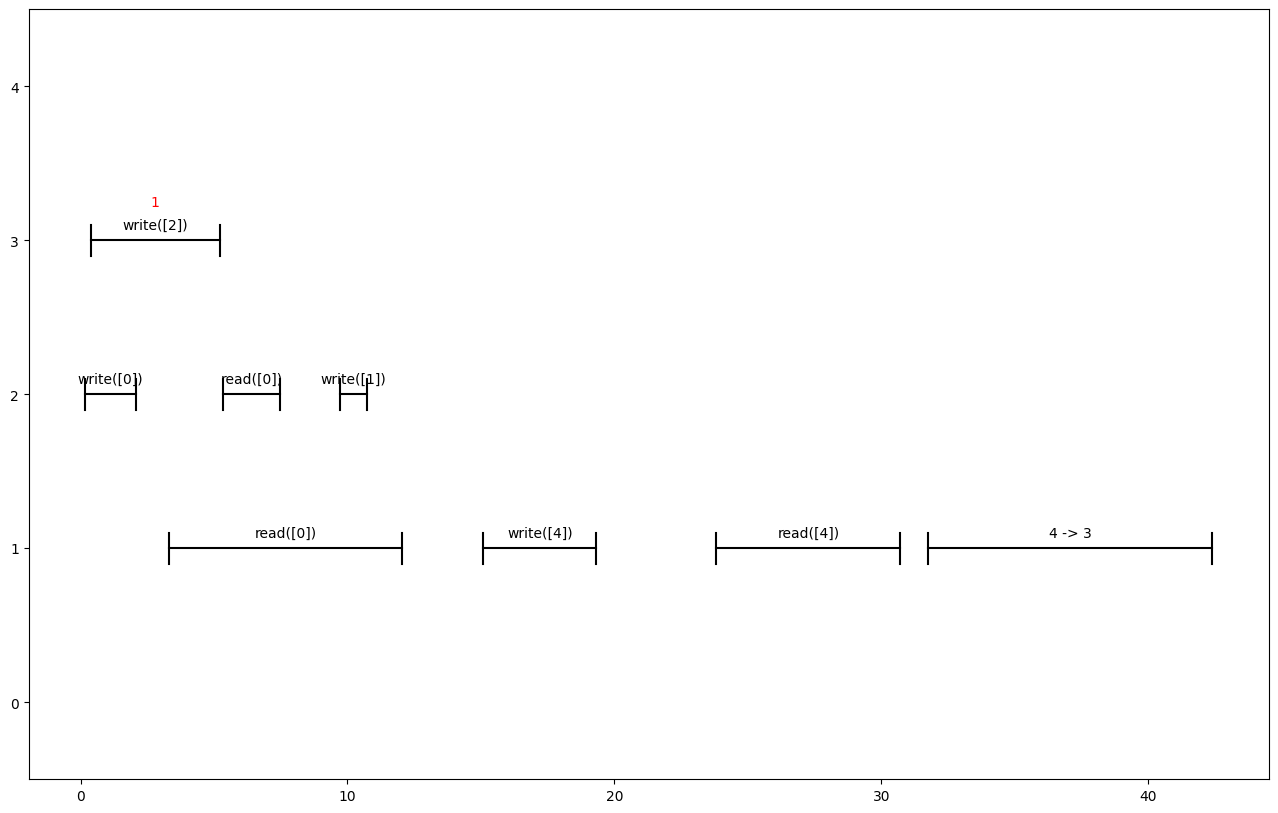

<IPython.core.display.Javascript object>

In [112]:
i = 0
testcase, res = copy.deepcopy(test[i])
print(f"Testcase {i} is {res}")
print(linearize_io(testcase))
visualize_history(testcase)

Testcase 4091 is False


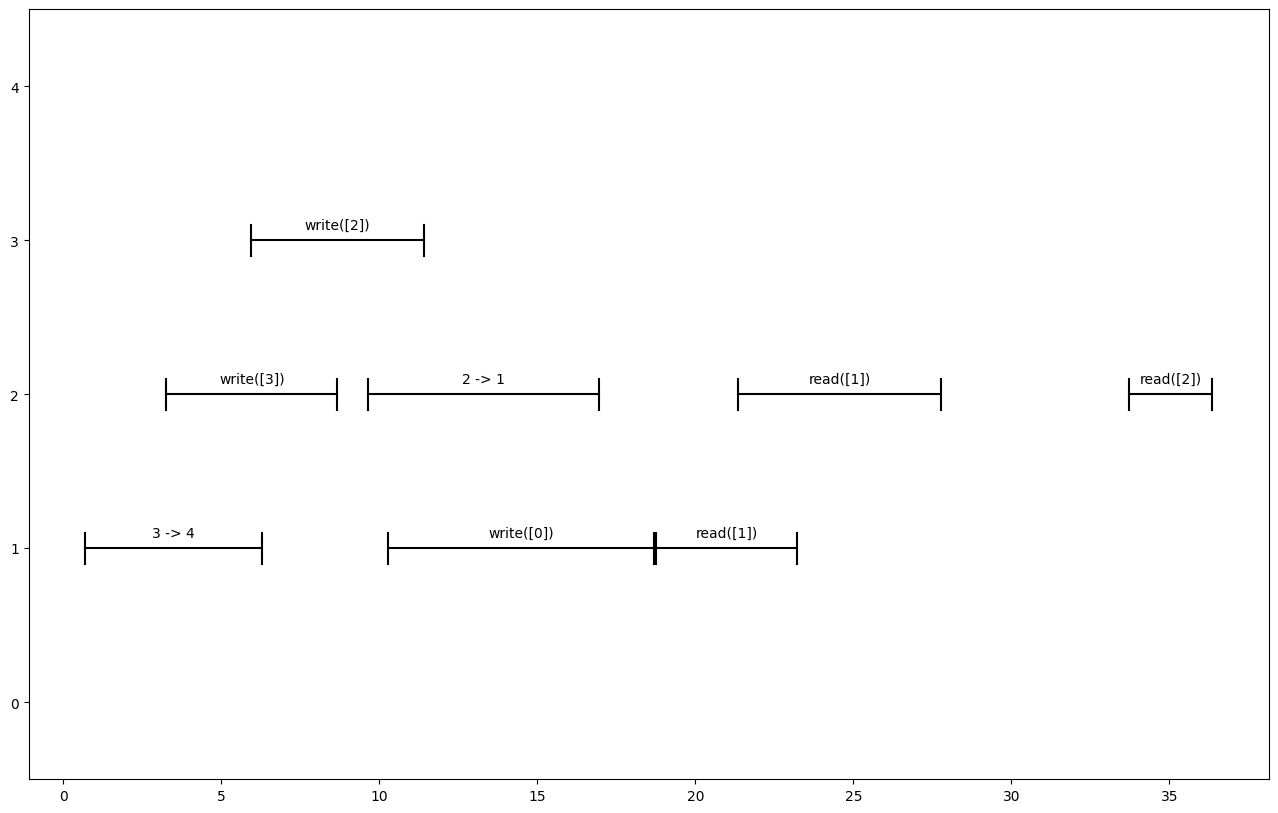

<IPython.core.display.Javascript object>

In [101]:
testcase, res = copy.deepcopy(test[i])
print(f"Testcase {i} is {res}")
visualize_history(testcase)

Testcase 8274 is False
True


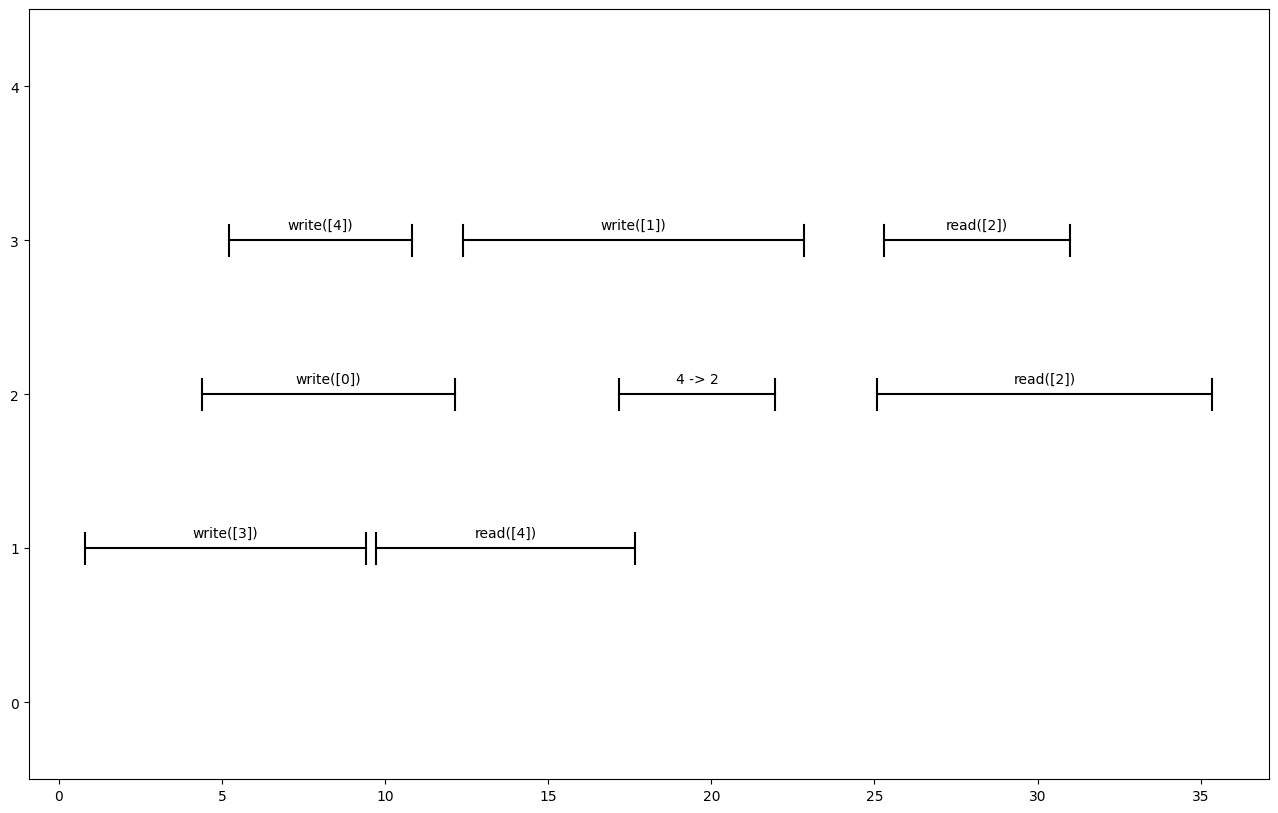

Testcase 10026 is False
True


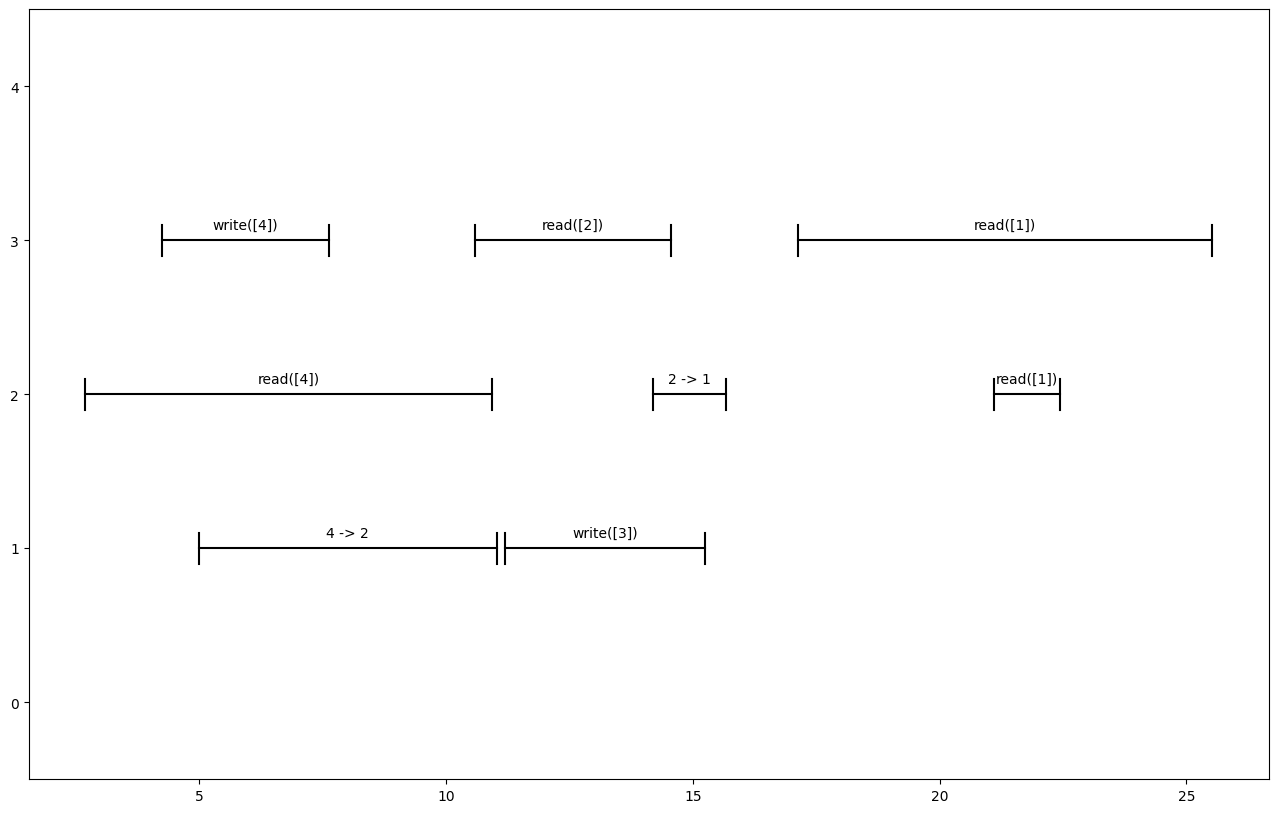

Testcase 11528 is False
True


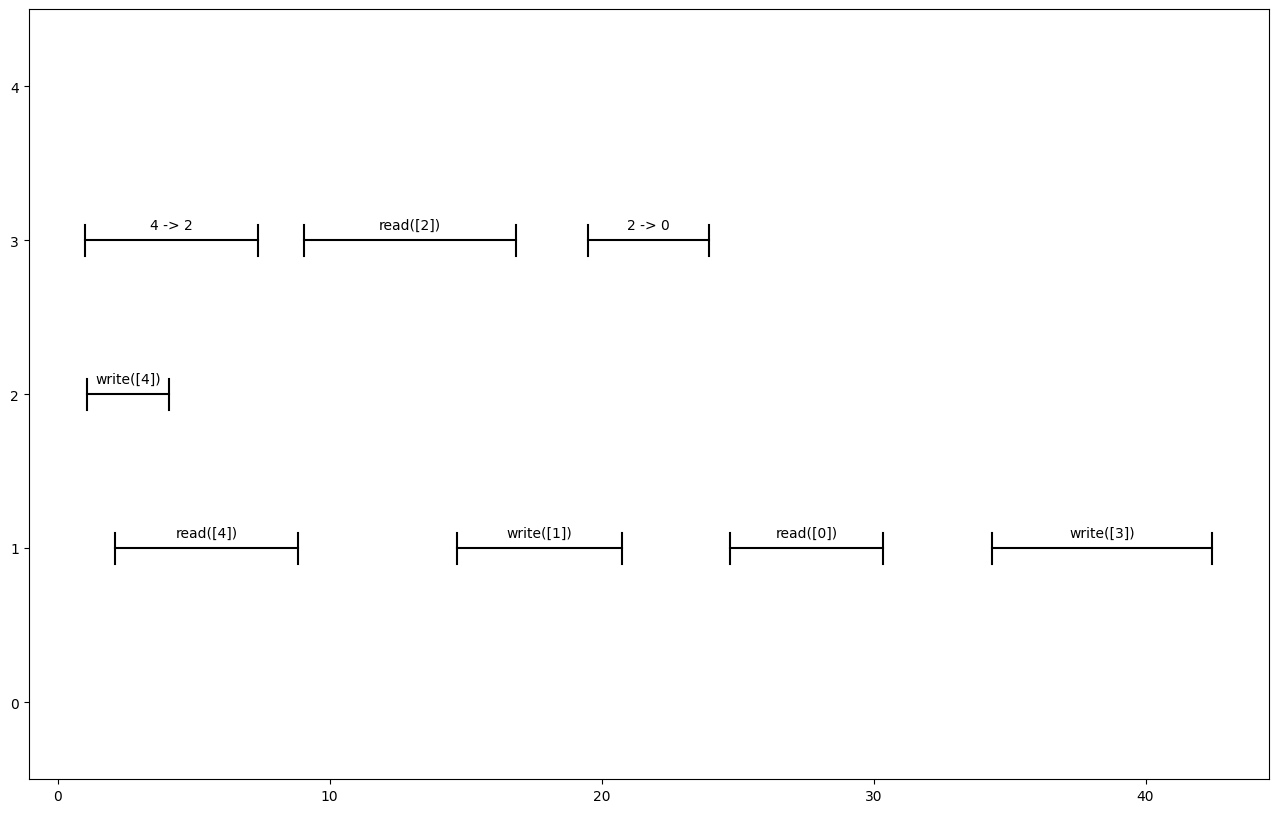

Testcase 12778 is False
True


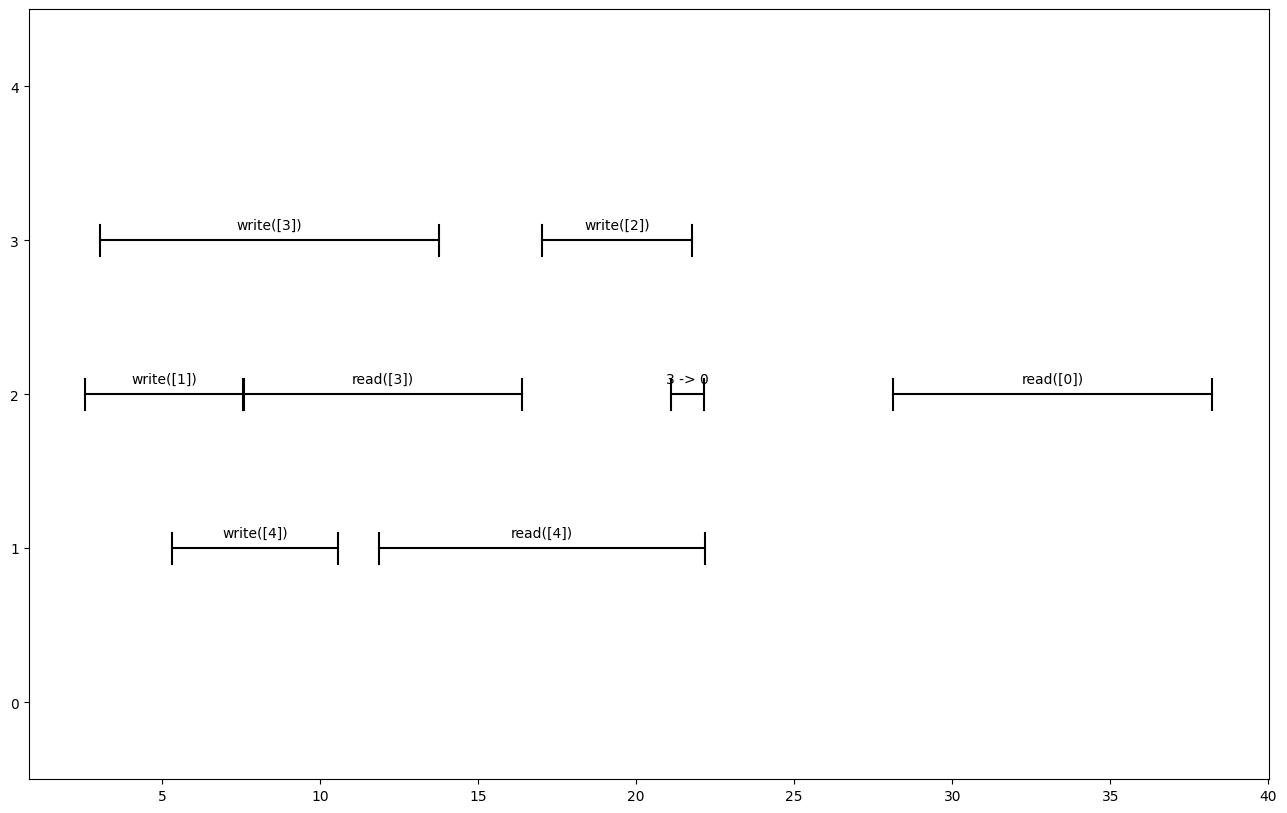

Testcase 16472 is False
True


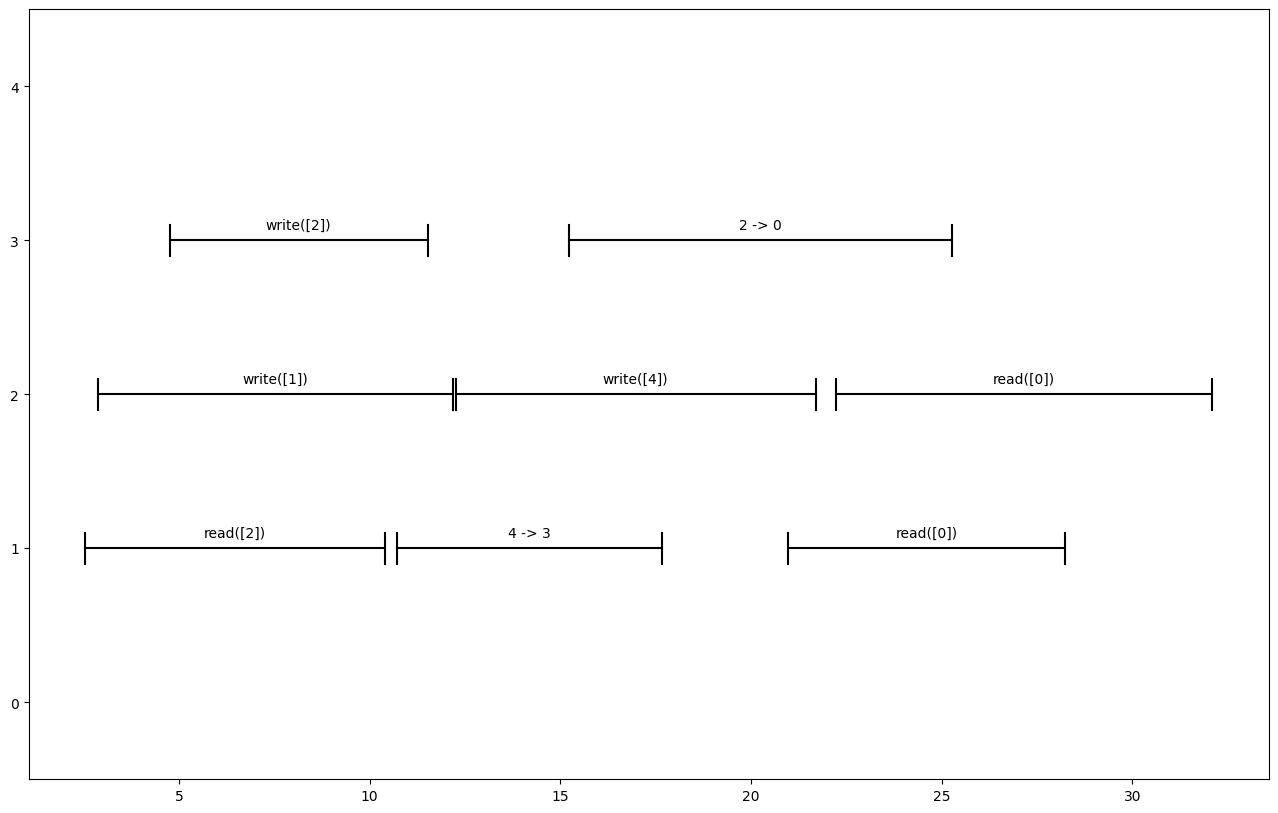

Testcase 17655 is False
True


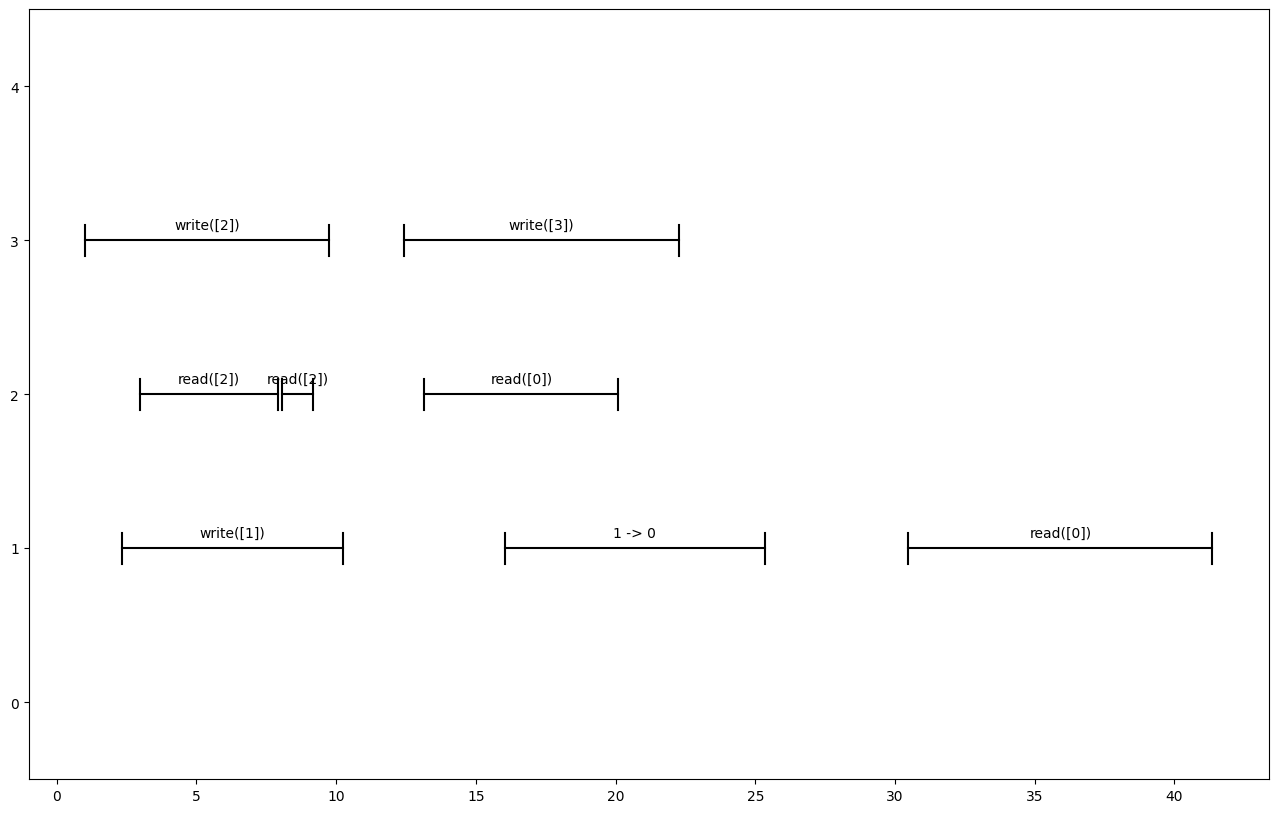

<IPython.core.display.Javascript object>

In [ ]:
if len(wrong_test_no) < 10:
    for wrong_test in wrong_test_no:
        testcase, res = copy.deepcopy(test[wrong_test])
        print(f"Testcase {wrong_test} is {res}")
        print(linearize_io(testcase))
        visualize_history(testcase)

True


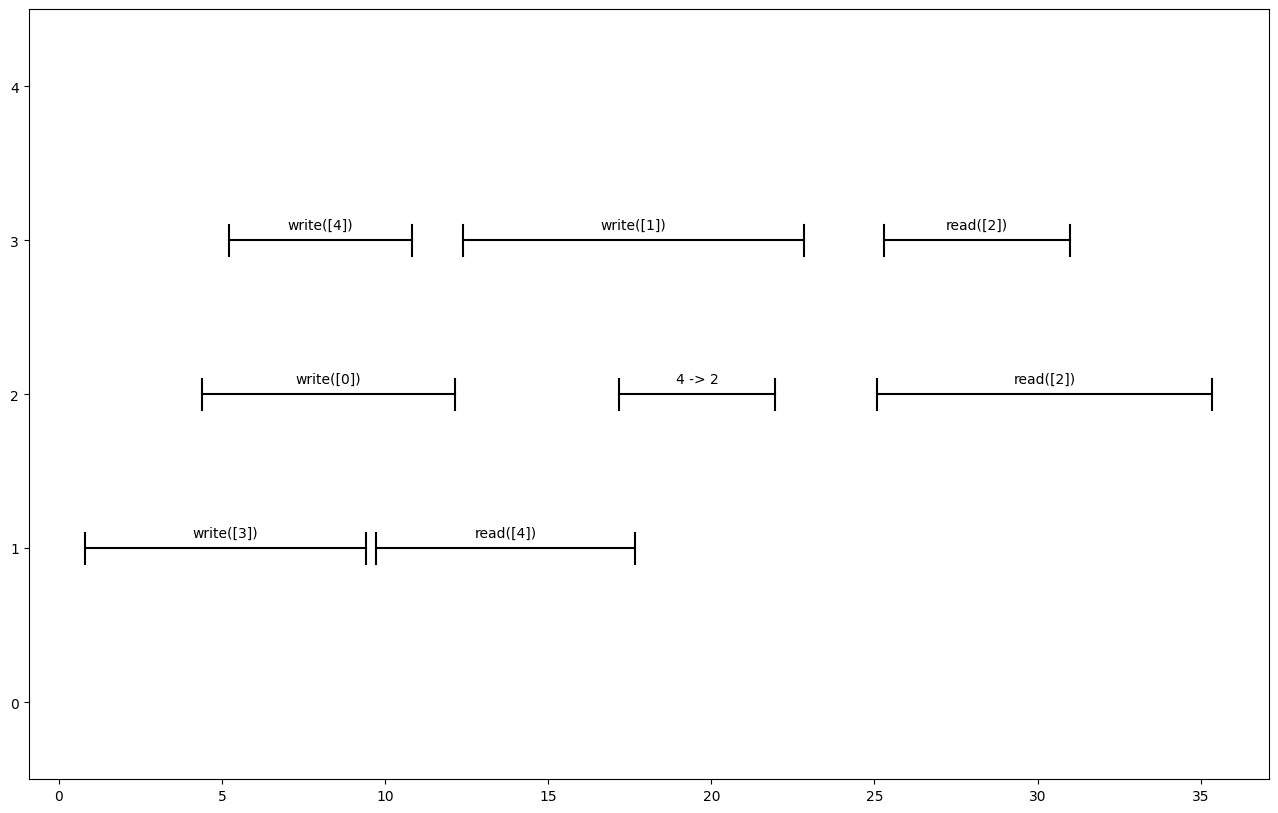

<IPython.core.display.Javascript object>

In [ ]:
testcase, res = copy.deepcopy(test[i])

print(linearize_io(testcase))
visualize_history(testcase)
